In [4]:
#@title Importing Packages
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#@title Initialization
DATA_WIDTH = 28
DATA_HEIGHT = 28
NUMBER_OF_TRAINING_EXAMPLES = 5000
NUMBER_OF_VALIDATION_EXAMPLES = 1000

ALL_TRAINING_IMAGES=[]
ALL_TRAINING_LABELS=[]
ALL_VALIDATION_IMAGES=[]
ALL_VALIDATION_LABELS=[]

In [6]:
#@title Functions
def _pixel_to_value(character):
    if(character == ' '):
        return 0
    elif(character == '#'):
        return 1
    elif(character == '+'):
        return 2  
    
def _value_to_pixel(value):
    if(value == 0):
        return ' '
    elif(value == 1):
        return '#'
    elif(value == 2):
        return '+'

def _load_data_file(filename, n, width, height):
    fin = [l[:-1] for l in open(filename).readlines()]
    fin.reverse()
    items = []
    for i in range(n):
        data = []
        for j in range(height):
            row = map(_pixel_to_value, list(fin.pop()))
            data.append(row)
        items.append(data)
    return items
        
def _load_label_file(filename, n):
    fin = [l[:-1] for l in open(filename).readlines()]
    labels = []
    for i in range(n):
        labels.append(int(fin[i]))
    return labels

def _load_all_data():
    ALL_TRAINING_IMAGES = _load_data_file("trainingimages",
        NUMBER_OF_TRAINING_EXAMPLES, DATA_WIDTH, DATA_HEIGHT)
    ALL_TRAINING_LABELS = _load_label_file("traininglabels",
        NUMBER_OF_TRAINING_EXAMPLES)

    ALL_VALIDATION_IMAGES = _load_data_file("validationimages",
        NUMBER_OF_VALIDATION_EXAMPLES, DATA_WIDTH, DATA_HEIGHT)
    ALL_VALIDATION_LABELS = _load_label_file("validationlabels",
        NUMBER_OF_VALIDATION_EXAMPLES)
    
    return ALL_TRAINING_IMAGES, ALL_TRAINING_LABELS, ALL_VALIDATION_IMAGES, ALL_VALIDATION_LABELS

def _print_digit_image(data):
    for row in range(len(data)):
        print(''.join(map(_value_to_pixel, data[row])))

def NormProb(mu, var, x):
  return 1/np.sqrt(2*np.pi*var) * np.exp(-1/2 * (x - mu)**2/var)

def Feature_Extraction(Data, DATA_WIDTH, DATA_HEIGHT):
  sharp_list = np.zeros(DATA_HEIGHT)
  plus_list = np.zeros(DATA_HEIGHT)
  width_row_list = np.zeros(DATA_HEIGHT)
  for row in range(DATA_HEIGHT):
    data = ''.join(map(_value_to_pixel, Data[row]))
    row_values = np.array(list(data))
    if np.where(row_values != ' ')[0].any():
      width_row_list[row] = np.max(np.where(row_values != ' ')) - np.min(np.where(row_values != ' '))
    sharp_list[row] = sum(row_values == '#')
    plus_list[row] = sum(row_values == '+')
  down = np.max(np.where((sharp_list + plus_list) != 0))
  up = np.min(np.where((sharp_list + plus_list) != 0))
  Hight = down - up + 1 #
  Width = np.max(width_row_list) + 1 #
  thr = up + int((down - up)/2)
  Sharp_num_upper = sum(sharp_list[:thr]) # 
  Plus_num_upper = sum(plus_list[:thr]) # 
  Sharp_num_below = sum(sharp_list[thr:]) # 
  Plus_num_below = sum(plus_list[thr:]) # 
  Row_limit = np.max(sharp_list + plus_list) / (DATA_WIDTH - np.max(sharp_list + plus_list)) #
  return Hight, Width, Sharp_num_upper, Sharp_num_below, Plus_num_upper, Plus_num_below, Row_limit

def Training(ALL_TRAINING_IMAGES, ALL_TRAINING_LABELS, DATA_WIDTH, DATA_HEIGHT):
  # Extractiong the Features
  Hight, Width, Sharp_num_upper, Sharp_num_below, Plus_num_upper, Plus_num_below, Row_limit = [], [], [], [], [], [], []
  for train in ALL_TRAINING_IMAGES:
    a, b, c, d, e, f, g = Feature_Extraction(train, DATA_WIDTH, DATA_HEIGHT)
    Hight.append(a); Width.append(b)
    Sharp_num_upper.append(c); Sharp_num_below.append(d)
    Plus_num_upper.append(e); Plus_num_below.append(f)
    Row_limit.append(g)
  Hight = np.array(Hight); Width = np.array(Width)
  Sharp_num_upper = np.array(Sharp_num_upper); Sharp_num_below = np.array(Sharp_num_upper)
  Plus_num_upper = np.array(Plus_num_upper); Plus_num_below = np.array(Plus_num_below)
  Row_limit = np.array(Row_limit)

  # Calculation of Prior and Lokelihood Probabilities 
  Prior = []
  x1_var, x2_var, x3_var, x4_var, x5_var, x6_var, x7_var = [], [], [], [], [], [], []
  x1_mean, x2_mean, x3_mean, x4_mean, x5_mean, x6_mean, x7_mean = [], [], [], [], [], [], []
  for i in range(10):
    Label_ind = (np.array(ALL_TRAINING_LABELS) == i)
    Prior.append(sum(Label_ind) / NUMBER_OF_TRAINING_EXAMPLES) 
    x1_var.append(np.var(Hight[Label_ind])); x1_mean.append(np.mean(Hight[Label_ind]))
    x2_var.append(np.var(Width[Label_ind])); x2_mean.append(np.mean(Width[Label_ind]))
    x3_var.append(np.var(Sharp_num_upper[Label_ind])); x3_mean.append(np.mean(Sharp_num_upper[Label_ind]))
    x4_var.append(np.var(Sharp_num_below[Label_ind])); x4_mean.append(np.mean(Sharp_num_below[Label_ind]))
    x5_var.append(np.var(Plus_num_upper[Label_ind])); x5_mean.append(np.mean(Plus_num_upper[Label_ind]))
    x6_var.append(np.var(Plus_num_below[Label_ind])); x6_mean.append(np.mean(Plus_num_below[Label_ind]))
    x7_var.append(np.var(Row_limit[Label_ind])); x7_mean.append(np.mean(Row_limit[Label_ind]))

  return Prior, (x1_var, x2_var, x3_var, x4_var, x5_var, x6_var, x7_var), (x1_mean, x2_mean, x3_mean, x4_mean, x5_mean, x6_mean, x7_mean)

def Classification(Test, DATA_WIDTH, DATA_HEIGHT, Prior, x1_var, x2_var, x3_var, x4_var, x5_var, x6_var, x7_var, x1_mean, x2_mean, x3_mean, x4_mean, x5_mean, x6_mean, x7_mean):
  Posterior = []
  x1, x2, x3, x4, x5, x6, x7 = Feature_Extraction(Test, DATA_WIDTH, DATA_HEIGHT)
  for i in range(10):
    p1 = NormProb(x1_mean[i], x1_var[i], x1)
    p2 = NormProb(x2_mean[i], x2_var[i], x2)
    p3 = NormProb(x3_mean[i], x3_var[i], x3)
    p4 = NormProb(x4_mean[i], x4_var[i], x4)
    p5 = NormProb(x5_mean[i], x5_var[i], x5)
    p6 = NormProb(x6_mean[i], x6_var[i], x6)
    p7 = NormProb(x7_mean[i], x7_var[i], x7)
    Posterior.append(Prior[i] * p1 *p2 * p3 * p4 * p5 * p6 *p7)
  return np.argmax(Posterior)

def Validation(DATA_WIDTH, DATA_HEIGHT, Prior, x1_var, x2_var, x3_var, x4_var, x5_var, x6_var, x7_var, x1_mean, x2_mean, x3_mean, x4_mean, x5_mean, x6_mean, x7_mean):
  Label_pred = []
  for Test in ALL_VALIDATION_IMAGES:
    label = Classification(Test, DATA_WIDTH, DATA_HEIGHT, Prior, x1_var, x2_var, x3_var, x4_var, x5_var, x6_var, x7_var, x1_mean, x2_mean, x3_mean, x4_mean, x5_mean, x6_mean, x7_mean)
    Label_pred.append(label)
  return Label_pred

In [8]:
#@title Loading all data and Printing a digit example 
ALL_TRAINING_IMAGES, ALL_TRAINING_LABELS, ALL_VALIDATION_IMAGES, ALL_VALIDATION_LABELS = _load_all_data()
example_number = random.randint(0, NUMBER_OF_TRAINING_EXAMPLES)
print("Printing digit example #" + str(example_number + 1) + " with label: " \
        + str(ALL_TRAINING_LABELS[example_number]))
_print_digit_image(ALL_TRAINING_IMAGES[example_number])

Printing digit example #4506 with label: 0
                            
                            
                            
                            
                            
               +++++++      
              # #####+      
          ++##########      
         +# ###########++   
        +#####++++++ ###    
       +####++       +###   
      +####+          +##   
     +####+           +##   
     +###+            ###   
     ####+           +###   
     ####            +###   
     ###+           +###+   
     ###+          +####    
     +##+         ++## +    
     +###++     ++####+     
     +#####+++++#####+      
      +##############+      
       +######### #         
        +++#######+         
                            
                            
                            
                            


In [9]:
#@title Extracting the Features and Calculation of Prior and Lokelihood Probabilities (on Train Data) 
Hight, Width, Sharp_num_upper, Sharp_num_below, Plus_num_upper, Plus_num_below, Row_limit = [], [], [], [], [], [], []
ALL_TRAINING_IMAGES, ALL_TRAINING_LABELS, ALL_VALIDATION_IMAGES, ALL_VALIDATION_LABELS = _load_all_data()
for train in ALL_TRAINING_IMAGES:
  a, b, c, d, e, f, g = Feature_Extraction(train, DATA_WIDTH, DATA_HEIGHT)
  Hight.append(a); Width.append(b)
  Sharp_num_upper.append(c); Sharp_num_below.append(d)
  Plus_num_upper.append(e); Plus_num_below.append(f)
  Row_limit.append(g)
Hight = np.array(Hight); Width = np.array(Width)
Sharp_num_upper = np.array(Sharp_num_upper); Sharp_num_below = np.array(Sharp_num_upper)
Plus_num_upper = np.array(Plus_num_upper); Plus_num_below = np.array(Plus_num_below)
Row_limit = np.array(Row_limit)

In [10]:
#@title Extracting the Features and Calculation of Prior and Lokelihood Probabilities (on Train Data) 
ALL_TRAINING_IMAGES, ALL_TRAINING_LABELS, ALL_VALIDATION_IMAGES, ALL_VALIDATION_LABELS = _load_all_data()
Prior, (x1_var, x2_var, x3_var, x4_var, x5_var, x6_var, x7_var), (x1_mean, x2_mean, x3_mean, x4_mean, x5_mean, x6_mean, x7_mean) = Training(ALL_TRAINING_IMAGES, ALL_TRAINING_LABELS, DATA_WIDTH, DATA_HEIGHT)

Naive-Bayes Classifier:
	Accuracy = 36.199999999999996%



Text(0.5, 1.0, 'Confusion Matrix on Validation Images')

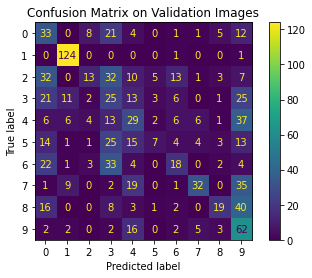

In [18]:
#@title Prediction the Validation Labels using Naive Bayes Classifier
_, _, ALL_VALIDATION_IMAGES, ALL_VALIDATION_LABELS = _load_all_data()
Label_pred = Validation(DATA_WIDTH, DATA_HEIGHT, Prior, x1_var, x2_var, x3_var, x4_var, x5_var, x6_var, x7_var, x1_mean, x2_mean, x3_mean, x4_mean, x5_mean, x6_mean, x7_mean)
Accuracy = sum(np.array(Label_pred) == np.array(ALL_VALIDATION_LABELS)) / len(ALL_VALIDATION_LABELS)
print(f'Naive-Bayes Classifier:\n\tAccuracy = {Accuracy*100}%\n')
ConfusionMatrixDisplay.from_predictions(ALL_VALIDATION_LABELS, Label_pred)
plt.title('Confusion Matrix on Validation Images')
